# SNP Colon Cancer Data-Set Balanced Missing Value

In this Ipython file we will work with balanced missing values on colon cancer data-set.
That is, if we remember the data-set, there are many missing values under 
the trail, pd1duz, pdl1poly, CD28, cd27snp, CD40 columns for colon and control individuals.
Our goal is balance the missing values of these samples and find the results of this data-set,
and compare with our decimal forms of data. So we will observe what will happens after appying some Imputation.
Notice that before applying imputation we converted our genotypes to decimal forms.

### Importing Modules

In [1]:
import sys
main_path = "../.."
sys.path.append(main_path)

import numpy as np
import pandas as pd
from impyute.imputation.cs import fast_knn
from impyute.imputation.cs import mice
from src.scripts.common_figures import Figures
from src.scripts.model_and_evaluation import ModelAndEvaluation
import seaborn as sns
import yaml

import warnings
warnings.simplefilter('ignore')

In [2]:
figures = Figures()
model_and_evaluation = ModelAndEvaluation()

### To get data and convert it to decimal forms

In [3]:
data = pd.read_csv(f'{main_path}/data/raw/colon_cancer.txt', sep="\t", encoding = "ISO-8859-1")
targets = np.ravel(data.iloc[:,0])
targets = np.where(targets == 'kontrol', 0, 1)
features = np.array(data.iloc[:,2:13])
columns = data.columns[2:13]

with open(f'{main_path}/config.yaml', 'r') as f:
    config = yaml.safe_load(f)
    
decimal_forms = config['decimal']

### A useful function to find and return feature importances

#### To convert data from categorical values to decimal forms

In [4]:
decimal_features = pd.DataFrame(features)
decimal_features.columns = columns
for col in decimal_features.columns:
    decimal_features[col] = decimal_features[col].map(decimal_forms)

In [5]:
sys.setrecursionlimit(100000) #Increase the recursion limit of the OS
cdt_knn = fast_knn(decimal_features.values, k=30)
cdt_knn = pd.DataFrame(cdt_knn, columns=columns)

cdt_mice = mice(decimal_features.values, random_state=1)
cdt_mice = pd.DataFrame(cdt_mice, columns=columns)

In [6]:
cdt_knn_fi = np.round(cdt_knn).astype('int').astype('str')
cdt_mice_fi = np.round(cdt_mice).astype('int').astype('str')

cdt_knn_fi_ohe = pd.get_dummies(cdt_knn_fi, sparse=True, columns=columns)
cdt_mice_fi_ohe = pd.get_dummies(cdt_mice_fi, sparse=True, columns=columns)

In [7]:
cdt_knn_fi_ohe_features = cdt_knn_fi_ohe.values
cdt_mice_fi_ohe_features = cdt_mice_fi_ohe.values

In [8]:
metric_results_wknn = model_and_evaluation.return_metric_results(cdt_knn_fi_ohe_features, targets)
metric_results_wmice = model_and_evaluation.return_metric_results(cdt_mice_fi_ohe_features, targets)

In [9]:
sns.set_context('poster', font_scale=0.8)

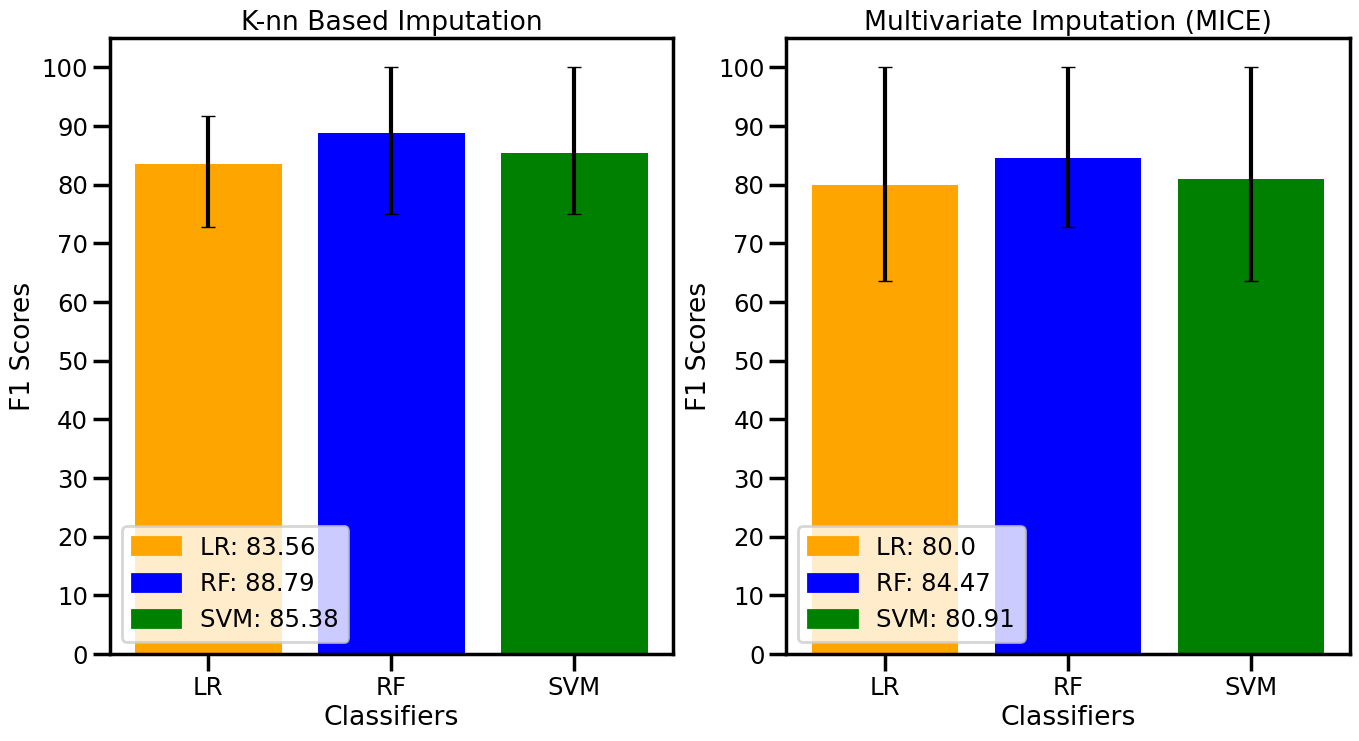

In [11]:
class_names = {'wknn': "K-nn Based Imputation",
              'wmice': "Multivariate Imputation (MICE)"}

classifier_names = ["LR", 'RF', 'SVM']

scores = {'wknn': [metric_results_wknn[i.lower()]['f1_scores'] for i in classifier_names],
          'wmice': [metric_results_wmice[i.lower()]['f1_scores'] for i in classifier_names]}

save = f"{main_path}/figures/paper_figures/png/f1_scores_imp_dec_forms_cdt_di_fi_ohe.png"
paper_figure = f"{main_path}/figures/paper_figures/svg/f1_scores_imp_dec_forms_cdt_di_fi_ohe.svg"
figures.draw_bar_plot(classifier_names, scores, class_names, grid_shape=(1, 2), save=save, paper_figure=paper_figure)